In [91]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [92]:
tsla = yf.Ticker("TSLA")

In [93]:
df_base = tsla.recommendations.reset_index() #Alyways have original df to refer back to 
df = df_base.copy()
df_base.head()

,Date,Firm,To Grade,From Grade,Action
0,2012-02-16 07:42:00,JP Morgan,Overweight,,main
1,2012-02-16 13:53:00,Wunderlich,Hold,,down
2,2012-02-17 06:17:00,Oxen Group,Buy,,init
3,2012-03-26 07:31:00,Wunderlich,Buy,,up
4,2012-05-22 05:57:00,Maxim Group,Buy,,init


In [94]:
import datetime as dt
df['Date'] = df['Date'].dt.floor('D') # Remove seconds
df['To Grade'].value_counts()

Neutral              56
Buy                  46
Outperform           34
Underperform         28
Hold                 28
Sell                 25
Underweight          22
Overweight           22
Equal-Weight         14
Market Outperform     6
Market Perform        6
Sector Perform        4
                      3
Peer Perform          1
Underperformer        1
Perform               1
In-Line               1
Sector Weight         1
Name: To Grade, dtype: int64

A lot of these terms mean the same thing, so let's group them into simpler Buy , Sell, Hold

In [95]:
df['To Grade'] = np.where((df['To Grade']== 'Outperform')|(df['To Grade']== 'Overweight')| (df['To Grade']== 'Strong Buy'),(
'Buy'),df['To Grade']) #Changing terms to Buy

In [96]:
df['To Grade'] = np.where((df['To Grade']== 'Neutral')|(df['To Grade']== 'Market Perform')| (df['To Grade']== 'Equal-Weight'),(
'Hold'),df['To Grade']) #Changing terms to Hold

In [97]:
df['To Grade'] = np.where((df['To Grade']== 'Underweight')|(df['To Grade']== 'Underperform'),(
'Sell'),df['To Grade']) #Changing terms to Sell

In [98]:
df['To Grade'].value_counts()

Hold                 104
Buy                  102
Sell                  75
Market Outperform      6
Sector Perform         4
                       3
Sector Weight          1
In-Line                1
Perform                1
Peer Perform           1
Underperformer         1
Name: To Grade, dtype: int64

In [99]:
#Remove any values that are not buy/sell/hold
df = df.loc[(df['To Grade'] == 'Hold')|(df['To Grade']=='Buy')|(df['To Grade']=='Sell')].copy()

In [100]:
df['Firm'].value_counts()

Morgan Stanley              28
Jefferies                   18
Wedbush                     18
JP Morgan                   16
Deutsche Bank               15
Goldman Sachs               15
Baird                       15
Canaccord Genuity           12
Barclays                    11
Credit Suisse               10
UBS                          9
Bank of America              8
RBC Capital                  7
Standpoint Research          7
B of A Securities            6
Piper Sandler                6
Citigroup                    6
Oppenheimer                  6
Roth Capital                 5
Nomura                       4
Cowen & Co.                  4
Stifel Nicolaus              4
New Street                   3
PiperJaffray                 3
JMP Securities               3
Pacific Crest                3
Wunderlich                   3
Argus Research               3
Exane BNP Paribas            2
Evercore ISI Group           2
Global Equities Research     2
CLSA                         2
Argus   

In [101]:
#Let's only evaluate firms with at least 10 recommendations
df = df.groupby("Firm").filter(lambda x: len(x) > 9).copy()
df['Firm'].value_counts()

Morgan Stanley       28
Wedbush              18
Jefferies            18
JP Morgan            16
Baird                15
Goldman Sachs        15
Deutsche Bank        15
Canaccord Genuity    12
Barclays             11
Credit Suisse        10
Name: Firm, dtype: int64

In [102]:
df['Action'].value_counts()

main    116
down     19
up       14
init      5
reit      4
Name: Action, dtype: int64

### Our df now has simplified recommendations and only companies that frequently provide recommendations for TSLA

### Time to bring in historical stock data so we can evaluate the recommendations

In [104]:
#Easy way to find date range 
df.describe()

,Date,Firm,To Grade,From Grade,Action
count,158,158,158,158,158
unique,129,10,3,11,5
top,2016-05-05 00:00:00,Morgan Stanley,Hold,,main
freq,4,28,69,111,116
first,2012-02-16 00:00:00,NaN,NaN,NaN,NaN
last,2020-07-23 00:00:00,NaN,NaN,NaN,NaN


In [105]:
prices = yf.download('TSLA', start='2012-01-01', end='2020-07-24', interval = '1d', progress=False)
prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,28.940001,29.500000,27.650000,28.080000,28.080000,928100
2012-01-04,28.209999,28.670000,27.500000,27.709999,27.709999,630100
2012-01-05,27.760000,27.930000,26.850000,27.120001,27.120001,1005500
2012-01-06,27.200001,27.790001,26.410000,26.910000,26.910000,986300
2012-01-09,27.000000,27.490000,26.120001,27.250000,27.250000,897000


In [106]:
df_buy = df.loc[df['To Grade']=='Buy']
df_sell = df.loc[df['To Grade']=='Sell']

In [107]:
#get buy and sell in prices df so we can scatter plot them on the price plot
plot_buy = prices.merge(df_buy,on='Date', how = 'left')
plot_sell = prices.merge(df_sell,on='Date', how = 'left')


In [108]:
plot_buy = plot_buy.loc[plot_buy['To Grade']=='Buy']
plot_sell = plot_sell.loc[plot_sell['To Grade']=='Sell']

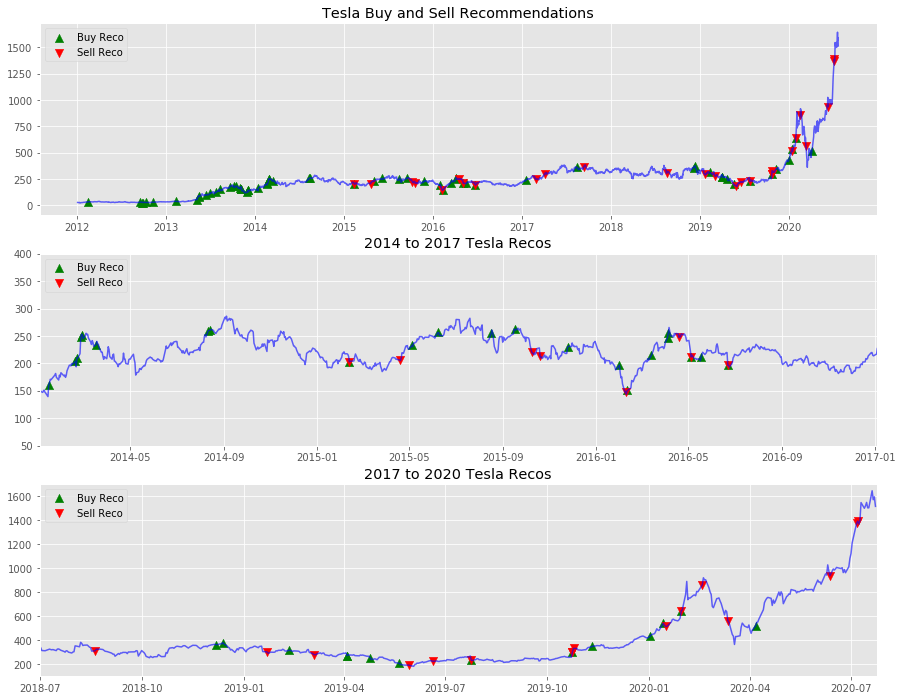

In [109]:
fig = plt.figure(figsize = (15,12))
plt.style.use('ggplot')

#variables for plot to make tweaking easier
line_alpha = 0.6
marker_alpha = 1
line_color = 'b'
buy_color = 'g'
sell_color = 'r'
marker_s = 70

ax1 = plt.subplot(3,1,1)
plt.plot(prices.index, prices.Close, color =line_color, alpha=line_alpha)
plt.scatter(x = plot_buy.Date, y = plot_buy.Close, color = buy_color, marker = '^', label = 'Buy Reco',s=marker_s, alpha = marker_alpha)
plt.scatter(x = plot_sell.Date, y = plot_sell.Close, color = sell_color, marker = 'v', label = 'Sell Reco',s=marker_s, alpha=marker_alpha)
ax1.set_title('Tesla Buy and Sell Recommendations')

ax2 = plt.subplot(3,1,2)
plt.plot(prices.index, prices.Close, color =line_color, alpha=line_alpha)
plt.scatter(x = plot_buy.Date, y = plot_buy.Close, color = buy_color, marker = '^', label = 'Buy Reco',s=marker_s, alpha = marker_alpha)
plt.scatter(x = plot_sell.Date, y = plot_sell.Close, color = sell_color, marker = 'v', label = 'Sell Reco',s=marker_s, alpha=marker_alpha)
ax2.set_title('2014 to 2017 Tesla Recos')

datemin2 = dt.date(2014, 1, 2)
datemax2 = dt.date(2017, 1, 3)
ax2.set_xlim(datemin2, datemax2)
ax2.set_ylim(50,400)

ax3 = plt.subplot(3,1,3)
plt.plot(prices.index, prices.Close, color =line_color, alpha=line_alpha)
plt.scatter(x = plot_buy.Date, y = plot_buy.Close, color = buy_color, marker = '^', label = 'Buy Reco',s=marker_s, alpha = marker_alpha)
plt.scatter(x = plot_sell.Date, y = plot_sell.Close, color = sell_color, marker = 'v', label = 'Sell Reco',s=marker_s, alpha=marker_alpha)
ax3.set_title('2017 to 2020 Tesla Recos')

datemin3 = dt.date(2018, 7, 1) #Not many recos between 2017 and 2018 and non volatile performance... just leave out
datemax3 = dt.date(2020, 7, 24)
ax3.set_xlim(datemin3, datemax3)
ax3.set_ylim(100,1700)

ax1.legend(loc=2)
ax2.legend(loc=2)
ax3.legend(loc=2)

#### We can see that sell recos outweigh buy recos when approaching/during Tesla's recent surge in price

In [110]:
df_surge = df.loc['2019-10-01':] #Set date before price surge
surge_gp = df_surge.groupby(['To Grade','Firm']).count().reset_index() #Will use this for a pivot table and then for bar plot
surge_gp.drop(columns = ['Date','From Grade'], inplace=True)

surge_pivot = surge_gp.pivot(index = 'Firm',
                            columns = 'To Grade',
                            values = 'Action')


surge_pivot.sort_values(by=['Sell','Hold'],ascending=False) #Ignore "To Grade" over the index...

To Grade,Buy,Hold,Sell
Firm,,,
Morgan Stanley,NaN,5.0,5.0
Credit Suisse,NaN,2.0,2.0
Barclays,NaN,NaN,2.0
JP Morgan,NaN,NaN,2.0
Wedbush,NaN,9.0,NaN
Canaccord Genuity,4.0,3.0,NaN
Baird,NaN,2.0,NaN
Deutsche Bank,NaN,2.0,NaN
Goldman Sachs,NaN,2.0,NaN


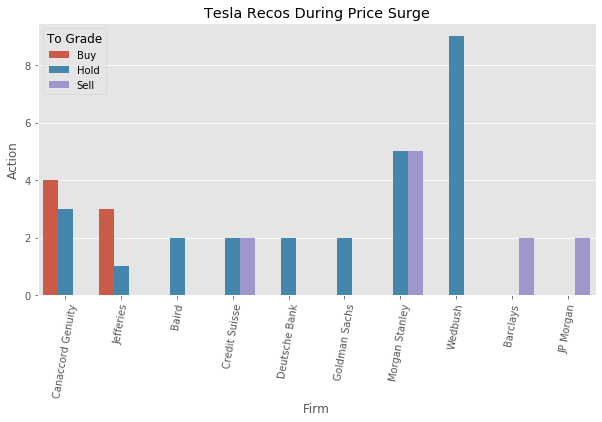

In [111]:
import seaborn as sns

plt.figure(figsize=(10,5))
ax = sns.barplot(x='Firm',y='Action', hue = 'To Grade',data = surge_gp)
ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
plt.title('Tesla Recos During Price Surge')

plt.show() #using plt.show to avoid annoying text

Morgan Stanley made the worst decisions during the recent price surge. Not only did they have the most sell recos, but they also had the second most hold recos, which we can consider a failed reco during a time of extrodinary growth

-----

Now that we have performed a visual analysis on reco types, we need to evaluate the stock performance after each recommendation

We will need to find the return for given periods after each recommendation has been made


In [112]:
df1 = prices.merge(df, on='Date',how='left') # Get recos and prices in one df

There are about 261 working days a year in the USA. Since our df only counts working days, we will need to use an adjusted time period

In [113]:
dt_adj = 261/365 #use to adjust our desired windows

df1['30 day return'] = df1.loc[:,'Close'].pct_change(periods = int(dt_adj*30))
df1['90 day return'] = df1.loc[:,'Close'].pct_change(periods = int(dt_adj*90))
df1['180 day return'] = df1.loc[:,'Close'].pct_change(periods = int(dt_adj*180))
df1['360 day return'] = df1.loc[:,'Close'].pct_change(periods = int(dt_adj*360))
df1.iloc[19:23] #Perfect... our 30 window starts 30 calender days later as epected

,Date,Open,High,Low,Close,Adj Close,Volume,Firm,To Grade,From Grade,Action,30 day return,90 day return,180 day return,360 day return
19,2012-01-31,29.900000,30.000000,28.870001,29.07,29.07,956400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,2012-02-01,29.070000,29.700001,29.000000,29.58,29.58,523200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2012-02-02,29.719999,30.879999,29.610001,30.25,30.25,805700,NaN,NaN,NaN,NaN,0.077279,NaN,NaN,NaN
22,2012-02-03,30.410000,31.330000,30.250000,31.15,31.15,764500,NaN,NaN,NaN,NaN,0.124143,NaN,NaN,NaN


In [114]:
df1.drop(columns = ['Open','High','Low','Adj Close','Volume','From Grade'],inplace= True)

Right now we have our 30 day return the day it occurs... we need to shift back our columns by the appropriate amount so we have the reco day and the future return on the same line

In [115]:
df1['30 day return'] = df1['30 day return'].shift(-int(dt_adj*30))
df1['90 day return'] = df1['30 day return'].shift(-int(dt_adj*90))
df1['180 day return'] = df1['30 day return'].shift(-int(dt_adj*180))
df1['360 day return'] = df1['30 day return'].shift(-int(dt_adj*360))
df1.head()

,Date,Close,Firm,To Grade,Action,30 day return,90 day return,180 day return,360 day return
0,2012-01-03,28.080000,NaN,NaN,NaN,0.077279,-0.090571,-0.087770,0.151322
1,2012-01-04,27.709999,NaN,NaN,NaN,0.124143,-0.058295,-0.039378,0.156043
2,2012-01-05,27.120001,NaN,NaN,NaN,0.172566,-0.089291,-0.069715,0.128909
3,2012-01-06,26.910000,NaN,NaN,NaN,0.174285,-0.073937,-0.066646,0.086217
4,2012-01-09,27.250000,NaN,NaN,NaN,0.171743,-0.003929,-0.084404,0.142525


df1 now has all of the information we need to evaluate Tesla's performance. We will come back to this df in the future when we want to break down return on recommendations by time period

In [116]:
return_gp = df1.groupby(['To Grade','Firm']).mean().reset_index()
return_gp.drop(columns = 'Close',inplace=True)

return_pivot_180 = return_gp.pivot(index = 'Firm',columns = 'To Grade',values = '180 day return')
return_pivot_180.sort_values(by= 'Buy',ascending = False,inplace=True)
return_pivot_180

To Grade,Buy,Hold,Sell
Firm,,,
Canaccord Genuity,0.319846,-0.078114,NaN
Goldman Sachs,0.195847,0.039998,0.063920
Morgan Stanley,0.163245,0.154000,NaN
Jefferies,0.103328,0.025258,NaN
JP Morgan,0.052186,-0.015598,-0.027635
Wedbush,0.032888,0.261722,NaN
Deutsche Bank,0.029493,0.015264,NaN
Baird,0.020613,-0.054570,NaN
Credit Suisse,-0.061670,NaN,0.176622


In [117]:
return_pivot_360 = return_gp.pivot(index = 'Firm',columns = 'To Grade',values = '360 day return')
return_pivot_360.sort_values(by= 'Buy',ascending = False,inplace=True)
return_pivot_360

To Grade,Buy,Hold,Sell
Firm,,,
Canaccord Genuity,0.194214,0.052775,NaN
Baird,0.105691,-0.045058,NaN
Wedbush,0.087450,-0.014818,NaN
JP Morgan,0.079487,-0.006593,0.067475
Deutsche Bank,0.060004,0.032766,NaN
Goldman Sachs,0.042070,0.020297,0.373993
Jefferies,0.030832,-0.024713,NaN
Credit Suisse,0.022083,NaN,NaN
Morgan Stanley,-0.040109,0.085162,NaN


### JP Morgan holds the top buy recos for 360 day periods and worst recos for 180 day periods
JP morgan does well with sell recos on the 360 day as well as the 180 day - both returns are quite low
### Goldman Sachs holds the worst buy recos for 360 day periods, but the best for 180 days
Goldman does awfully with sell recos for their 180 day as the mean return after a sell reco was 20%

In [118]:
#Need to format df so that it can be used in a boxplot
return_melt = return_gp.melt(id_vars=['To Grade','Firm'])
return_melt.head()

,To Grade,Firm,variable,value
0,Buy,Baird,30 day return,0.078168
1,Buy,Canaccord Genuity,30 day return,0.053976
2,Buy,Credit Suisse,30 day return,0.062240
3,Buy,Deutsche Bank,30 day return,0.096808
4,Buy,Goldman Sachs,30 day return,0.005843


Text(0.5, 0, 'Return Window')

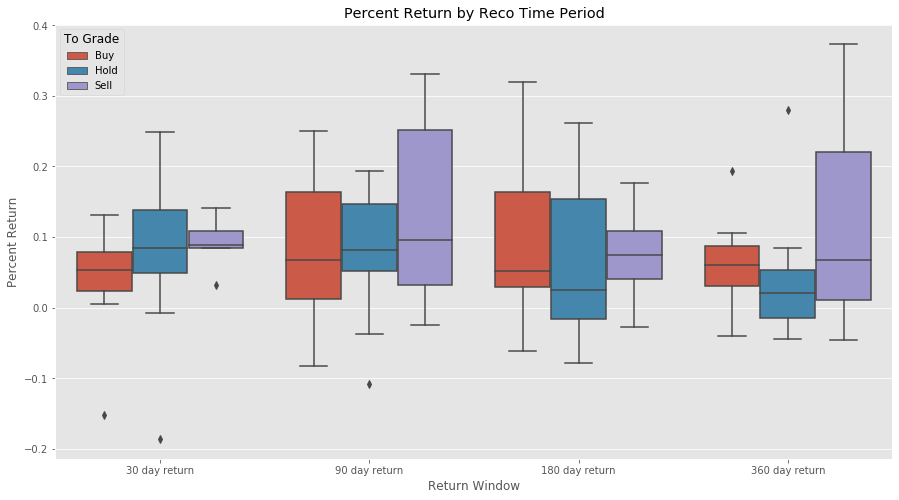

In [121]:
plt.figure(figsize = (15,8))
sns.boxplot(x='variable',y = 'value', hue = 'To Grade',data = return_melt)
plt.title('Percent Return by Reco Time Period')
plt.ylabel('Percent Return')
plt.xlabel('Return Window')

### It is evident that most analysts have no idea what is going on with Tesla. The percent return after a Sell reco has the highest median return across all time periods except for 180 days. 

### Moreover, the interquartile range for Sell is more favourable than buy for all time periods except 180 days.